# Summary

In [1]:
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import sys
from glob import glob
#import h5py
import os
import contextlib
from os.path import exists

In [2]:
#from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
import pandas as pd
import seaborn as sns
sys.path.append('../../algorithms')
import trainingvariables
import datatools
import helper
sys.path.append('../..')
#sys.path.append('/tools/Xilinx/Vivado/Vivado/2019.2/bin')

os.environ['PATH'] = os.environ['PATH'] + ':/tools/Xilinx/Vivado/Vivado/2019.2/bin'

import config
new_card='atlas_nsw_pad_z0'
#new_card=new_card + '_stg2BC'
#new_card=new_card + '_stg300um'
new_card=new_card + '_mm4BC'
DATA_LOC=config.DATA_LOC_VALIDATE
DATA_LOC=DATA_LOC.replace(config.CARD,new_card)
print("# WARNING: data path changed!!!!")
files=glob(f"{DATA_LOC}")
hls_report = {}
#norm is normalization for std, it is the std of the chi2 fit
from helper import plot_performance, conv_to_hls, compile_predict_profile, diff_dataset_plot
from helper import norm_a, norm_x, mult_fact, mult_facta
%matplotlib inline
#norm_a = 0.43
#norm_x = 0.102
#mult_fact = 20
#mult_facta = 0.1167
mod_dir = "/afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/algorithms/models/"

# WARNING: data path changed!!!!


/srv/conda/envs/notebook/lib/python3.7/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [3]:
model_list_normal   = glob(mod_dir+"MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_1*_PRUNED50")
model_list_stg2BC   = glob(mod_dir+"MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_2*_PRUNED50")
model_list_stg300um = glob(mod_dir+"MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_3*_PRUNED50")
model_list_mm4BC    = glob(mod_dir+"MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4*_PRUNED50")

In [4]:
model_list_normal

['/afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/algorithms/models/MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_114_4Outputs_LONG_PRUNED50',
 '/afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/algorithms/models/MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_116_4Outputs_LONG_PRUNED50',
 '/afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/algorithms/models/MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_118_4Outputs_LONG_PRUNED50',
 '/afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/algorithms/models/MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_120_4Outputs_LONG_PRUNED50',
 '/afs/cern.ch/w

In [5]:
mods = []
mods.append(
{'name': "lar2_p50_nominal", 'plot_name':'Nominal',
'dirs': model_list_normal,
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none','card':'atlas_nsw_pad_z0'})
mods.append(
{'name': "lar2_p50_stg2BC", 'plot_name':'stg2BC',
'dirs': model_list_stg2BC,
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none','card':'atlas_nsw_pad_z0_stg2BC'})
mods.append(
{'name': "lar2_p50_stg300um", 'plot_name':'stg300um',
'dirs': model_list_stg300um,
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none','card':'atlas_nsw_pad_z0_stg300um'})
mods.append(
{'name': "lar2_p50_mm4BC", 'plot_name':'mm4BC',
'dirs': model_list_mm4BC,
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none','card':'atlas_nsw_pad_z0_mm4BC'})
cards={}
cards['Nominal'] = 'atlas_nsw_pad_z0'
cards['stg2BC'] = 'atlas_nsw_pad_z0_stg2BC'
cards['stg300um'] = 'atlas_nsw_pad_z0_stg300um'
cards['mm4BC'] = 'atlas_nsw_pad_z0_mm4BC'


In [6]:
results = {}

In [19]:

summary_x = {}
summary_a = {}
summary_mse_x = {}
summary_mse_a = {}
summary_percentil_x = {}
summary_percentil_a = {}

model_l = []
card_l = []
run_l  = []
x_stds = []
a_stds = []
x_mses = []
a_mses = []
x_perc = []
a_perc = []
for model_ in mods:
    results[model_['name']] = {}
    for card in cards.keys():
        for model_dir in model_['dirs']:
            json_file = model_dir + f'/hls4ml_results_{cards[card]}.npy'
            print('file: ' + json_file)
            FILE_EXISTS = exists(json_file)
            if FILE_EXISTS:
                print(f"# INFO: loading saved report for model {model_['name']}")
                results[model_['name']][card] = np.load(json_file,allow_pickle=True).item()
            else:
                print(f"# ERROR: report not found for model {model['name']} and card {cards[card]}")
            model_l.append(model_['plot_name'])
            card_l.append(card)
            run_l.append(results[model_['name']][card]['run'])
            x_stds.append(results[model_['name']][card]['x_std_hls']/norm_x)
            a_stds.append(results[model_['name']][card]['a_std_hls']/norm_a)
            x_mses.append(results[model_['name']][card]['x_mse_keras'])
            a_mses.append(results[model_['name']][card]['a_mse_keras'])
            x_perc.append(results[model_['name']][card]['x_percentil']/norm_x)
            a_perc.append(results[model_['name']][card]['a_percentil']/norm_a)
#    summary_x[model['plot_name']] = x_stds.copy()
#    summary_a[model['plot_name']] = a_stds.copy()
#    summary_mse_x[model['plot_name']] = x_mses.copy()
#    summary_mse_a[model['plot_name']] = a_mses.copy()
#    summary_percentil_x[model['plot_name']] = x_perc.copy()
#    summary_percentil_a[model['plot_name']] = a_perc.copy()


file: /afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/algorithms/models/MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_114_4Outputs_LONG_PRUNED50/hls4ml_results_atlas_nsw_pad_z0.npy
# INFO: loading saved report for model lar2_p50_nominal
file: /afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/algorithms/models/MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_116_4Outputs_LONG_PRUNED50/hls4ml_results_atlas_nsw_pad_z0.npy
# INFO: loading saved report for model lar2_p50_nominal
file: /afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/algorithms/models/MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_118_4Outputs_LONG_PRUNED50/hls4ml_results_atlas_nsw_pad_z0.npy
# INFO: loading saved report for mod

In [20]:
data = {'model': model_l,
        'card': card_l,
        'run': run_l,
        'x_std': x_stds,
        'a_std': a_stds,
        'x_mse': x_mses,
        'a_mse': a_mses,
        'x_perc': x_perc,
        'a_perc': a_perc}
df = pd.DataFrame(data)

In [40]:
def plot_summary_perf(df, var='x_std', ylim=[0,20],save=False):
    print ()
    mask = df[var] < ylim[1]
    # Select rows that satisfy the condition specified by the mask
    subset_df = df[mask]

    min_vals = (df.groupby(['model', 'card'])
                  [var]
                  .min()
                  .reset_index()
                  )

    # Convert 'model' to a numerical variable using factorize()
    _, model_idx = pd.factorize(df['model'])
    _, card_idx = pd.factorize(df['card'])
    # Create a new column in min_vals that combines 'model' and 'card' into a single string column
    plt.figure(figsize=(10,8), dpi= 80)

    # Plot the box plot with hue='card'
    sns.boxplot(x='model', y=var, data=subset_df, hue='card')

    # Add text annotations for the minimum values of each subgroup
    for row in min_vals.itertuples():
        model, card, min_val = row.model, row.card, row[3]
        x_pos = model_idx.get_loc(model) + card_idx.get_loc(card)/4 -0.35
        plt.text(x_pos, min_val-1, f"{min_val:.1f}", horizontalalignment='center', fontdict={'size':14}, color='gray')

    # Draw vertical lines between the boxes
    for i in range(len(df['model'].unique())-1):
        plt.vlines(i+.5, 10, 45, linestyles='solid', colors='gray', alpha=0.2)

    # Decoration
    plt.title(f'{var} of models with different training', fontsize=20)
    plt.legend(title='Test dataset',fontsize=16, title_fontsize=16)
    plt.xlabel("training dataset",fontsize=20)
    plt.ylabel(f"{var} [units]",fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.ylim(ylim)
    if save:
        plt.savefig(f'model_plots/summary_{var}.pdf')
        plt.savefig(f'model_plots/summary_{var}.png')


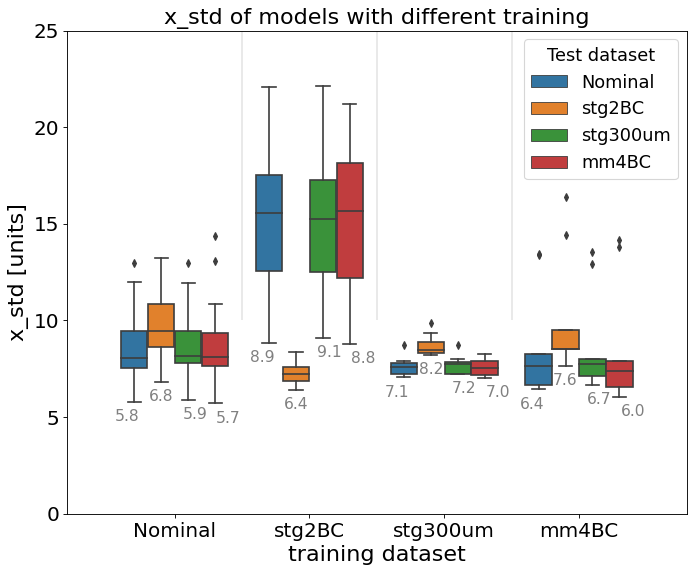

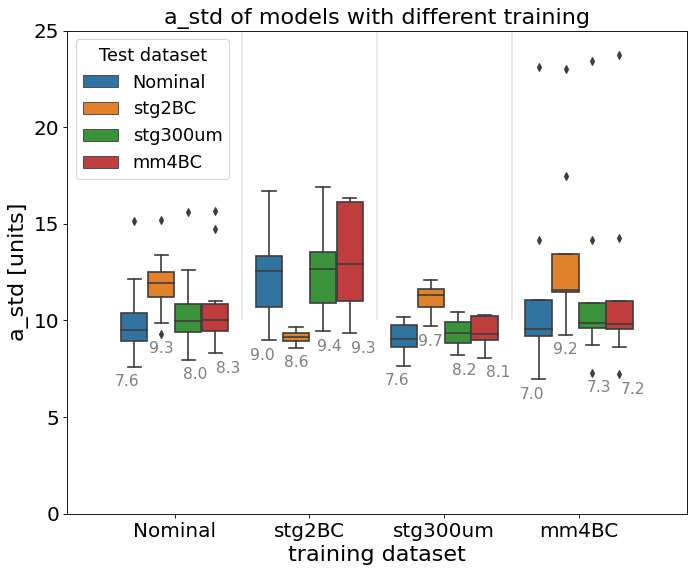

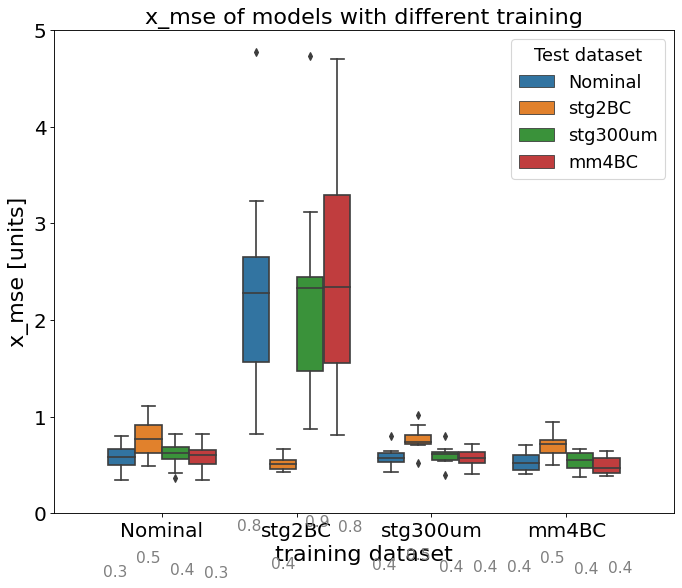

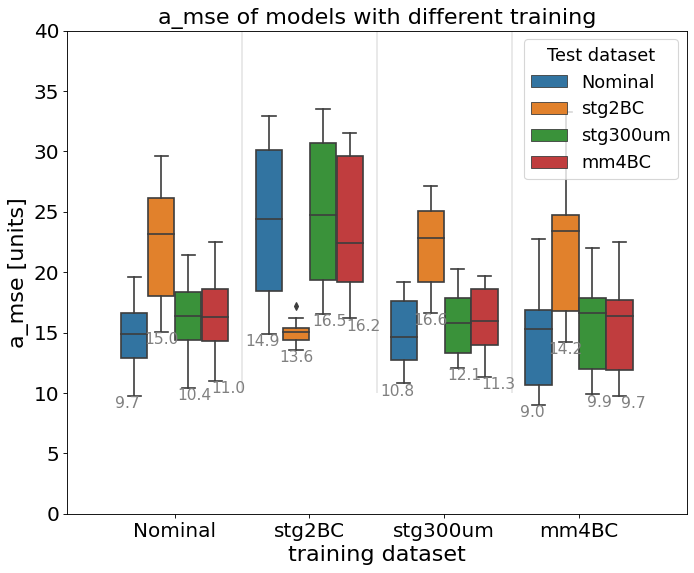

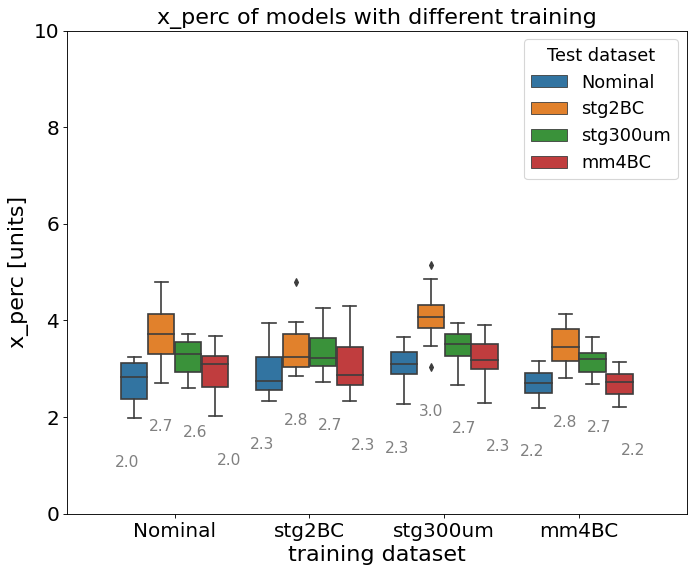

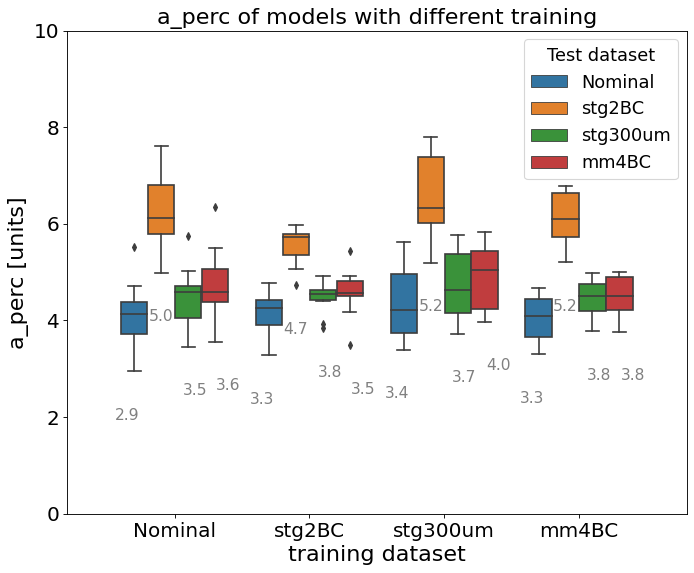

In [41]:
plot_summary_perf(df,'x_std',[0,25],True)
plot_summary_perf(df,'a_std',[0,25],True)
plot_summary_perf(df,'x_mse',[0,5])
plot_summary_perf(df,'a_mse',[0,40])
plot_summary_perf(df,'x_perc',[0,10],True)
plot_summary_perf(df,'a_perc',[0,10],True)


In [ ]:
diff_dataset_plot(summary_x, list(cards.keys()), title='x regression std for different dataset training')
diff_dataset_plot(summary_percentil_x, list(cards.keys()), 'x quantile for different dataset training', y_lim=[0,10])
#diff_dataset_plot(summary_percentil_a, list(cards.keys()), 'Angle quantile for different dataset training', y_lim=[0,10])

# Generate